# ***Amazon Product Reviews Sentiment Analysis with Machine Learning***  

**NEGATIVE**: Totally dissatisfied with the service. Worst customer care ever.  
**NEUTRAL**: Good Job but i will expect a lot more in future.  
**POSITIVE**: Brillant effort guys! Love Your Work.  




---
Les critiques de produits deviennent de plus en plus importantes avec l'évolution des magasins de détail traditionnels vers les achats en ligne.  
  
Les consommateurs publient des avis directement sur les pages produits en temps réel. Avec la grande quantité d'avis de consommateurs, cela crée une opportunité de voir comment le marché réagit à un produit spécifique.  
  
Nous essaierons de voir si nous pouvons prédire le sentiment d'une critique de produit à l'aide de python et de l'apprentissage automatique.  


---




## ***Importons les modules nécessaires et jetons un oeil aux données***  


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')  # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
sns.set_style("whitegrid")  # Plotting style
np.random.seed(7)  # seeding random number generator

df = pd.read_csv("/content/amazon.csv")
print(df.shape)
df.head()


(34660, 21)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


## ***Décrire l'ensemble de données***

In [3]:
data  = df.copy()
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

Nous devons nettoyer la colonne de nom en référençant les asins(produits uniques) car nous avons 7000 valeurs manuantes.

In [6]:
data["asins"].unique()

array(['B01AHB9CN2', 'B00VINDBJK', 'B005PB2T0S', 'B002Y27P3M',
       'B01AHB9CYG', 'B01AHB9C1E', 'B01J2G4VBG', 'B00ZV9PXP2',
       'B0083Q04TA', 'B018Y229OU', 'B00REQKWGA', 'B00IOYAM4I',
       'B018T075DC', nan, 'B00DU15MU4', 'B018Y225IA', 'B005PB2T2Q',
       'B018Y23MNM', 'B00OQVZDJM', 'B00IOY8XWQ', 'B00LO29KXQ',
       'B00QJDU3KY', 'B018Y22C2Y', 'B01BFIBRIE', 'B01J4ORNHU',
       'B018SZT3BK', 'B00UH4D8G2', 'B018Y22BI4', 'B00TSUGXKE',
       'B00L9EPT8O,B01E6AO69U', 'B018Y23P7K', 'B00X4WHP5E', 'B00QFQRELG',
       'B00LW9XOJM', 'B00QL1ZN3G', 'B0189XYY0Q', 'B01BH83OOM',
       'B00BFJAHF8', 'B00U3FPN4U', 'B002Y27P6Y', 'B006GWO5NE',
       'B006GWO5WK'], dtype=object)

In [7]:
asins_unique = len(data["asins"].unique())
print("Nombre d'ASIN uniques:" + str(asins_unique))

Nombre d'ASIN uniques:42


## ***Visualiser les distributions des variables numériques:***

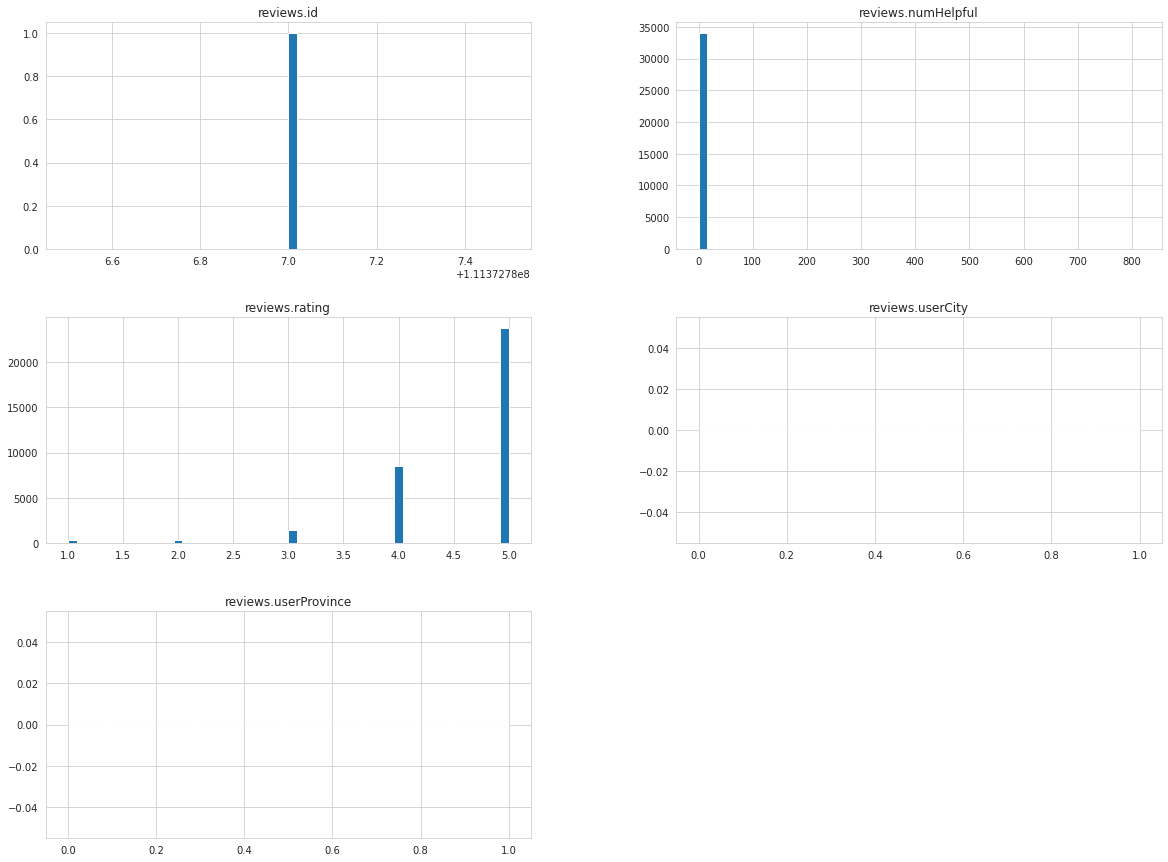

In [8]:
data.hist(bins=50, figsize=(20,15))
plt.show()

Les valeurs aberrantes dans ce cas sont précieuses, nous voudrons donc peut-être pondérer les avis dont plus de 50 personnes les trouvent utiles.  
  
La majorité des exemples ont reçu une note élevée(en regardant la distribution des notes ). Il y a deux fois plus de 5 étoiles que les autres notes combinées.  

## ***Divisez les données en Train et Test***  
  
Avant d'explorer l'ensemble de données, nous le diviserons en ensemble d'entraînement et en ensembles de test. Finalement, notre objectif est de former un classificateur d'analyse des sentiments.  
  
Etant donné que la majorité des avis sont positifs (5 étoiles), nous devrons effectuer une répartition stratifiée du score des avis pour nous assurer de ne pas former le classificateur sur des données déséquilibrées.  
   


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["reviews.rating"])

# Removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["reviews.rating"] = dataAfter["reviews.rating"].astype(int)

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

for train_index, test_index in split.split(dataAfter, dataAfter["reviews.rating"]):
  strat_train = dataAfter.reindex(train_index)
  strat_test = dataAfter.reindex(test_index)

Before 34660
After 34627


Nous devons voir si les ensembles de train et de test ont été stratifiés proportionnellement par rapport aux données brutes:

In [10]:
print(len(strat_train))
print(len(strat_test))

print(strat_test["reviews.rating"].value_counts() /len(strat_test) )

27701
6926
5.0    0.689864
4.0    0.244730
3.0    0.042160
1.0    0.011406
2.0    0.011118
Name: reviews.rating, dtype: float64


## ***Exploration de données (ensemble de formation)***  
  
Nous utiliserons des expressions régulières pour nettoyer tous les caractères défavorables dans l'ensemble de données, puis prévisualiserons à quoi ressemblent les données après le nettoyage.  

In [11]:
reviews = strat_train.copy()
reviews.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
4349,AVphgVaX1cnluZ0-DR74,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B018Y229OU,Amazon,"Fire Tablets,Tablets,Computers & Tablets,All T...",firetablet7displaywifi8gbincludesspecialoffers...,Amazon,2015-11-28T00:00:00.000Z,2017-05-21T04:06:08Z,"2017-04-30T00:26:00.000Z,2017-06-07T08:10:00.000Z",NaN,True,NaN,5.0,5.0,http://reviews.bestbuy.com/3545/5025800/review...,we bought this for my 11 year old daughter and...,great for all ages,NaN,NaN,Mark
30776,AV1YE_muvKc47QAVgpwE,NaN,B00U3FPN4U,Amazon Fire Tv,"Back To College,College Electronics,College Tv...","848719057492,amazonfiretv/51454342,amazonfiret...",Amazon,2017-01-06T00:00:00.000Z,2017-09-20T05:35:55Z,"2017-08-25T22:21:42.763Z,2017-08-19T09:26:46.1...",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/4370400/review...,"I have the Roku 4, and new Apple TV, this stre...",Great streaming box,NaN,NaN,Techno
28775,AVpidLjVilAPnD_xEVpI,NaN,B0189XYY0Q,Amazon Fire,"Electronics,Tablets & E-Readers,Tablets,Back T...","841667101743,amazonfire/51441641,amazonfirehd1...",Amazon,2017-03-11T00:00:00.000Z,NaN,"2017-09-03T08:45:20.825Z,2017-08-27T11:01:01.1...",NaN,False,NaN,0.0,3.0,http://reviews.bestbuy.com/3545/5386601/review...,This is my 3rd Kindle. I have continued to mov...,My 3rd Kindle,NaN,NaN,Sunshine
1136,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-02-04T00:00:00.000Z,2017-05-21T05:56:10Z,"2017-04-30T00:42:00.000Z,2017-06-07T09:04:00.000Z",NaN,True,NaN,1.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,enjoying reading via the device; lots of optio...,easy to use; a little heavy to hold,NaN,NaN,bird
17803,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,B00OQVZDJM,Amazon,"Walmart for Business,Office Electronics,Tablet...","amazon/b00oqvzdjm,848719056099,amazonkindlepap...",Amazon,2015-10-22T00:00:00.000Z,2017-09-05T22:09:30Z,"2017-08-31T22:34:06.437Z,2017-08-02T19:49:50.3...",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/9439005/review...,"If you want an e book reader that is light, ea...",As an e reader this is great!,NaN,NaN,Thomas


In [12]:
print(len(reviews["name"].unique()), len(reviews["asins"].unique()))
print(reviews.info())
print(reviews.groupby("asins")["name"].unique())

47 35
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27701 entries, 4349 to 29636
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27673 non-null  object 
 1   name                  22268 non-null  object 
 2   asins                 27672 non-null  object 
 3   brand                 27673 non-null  object 
 4   categories            27673 non-null  object 
 5   keys                  27673 non-null  object 
 6   manufacturer          27673 non-null  object 
 7   reviews.date          27659 non-null  object 
 8   reviews.dateAdded     19228 non-null  object 
 9   reviews.dateSeen      27673 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   27257 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    27304 non-null  float64
 14  reviews.rating        27673 non-null  float64
 15  reviews.so

Permet de voir tous les différents noms de ce produit qui ont 2 ASIN:

In [13]:
different_names = reviews[reviews["asins"] == "B00L9EPT8O,B01E6AO69U"]["name"].unique()

for name in different_names:
  print(name)

print(reviews[reviews["asins"] == "B00L9EPT8O,B01E6AO69U"]["name"].value_counts())

Echo (White),,,
Echo (White),,,
Amazon Fire Tv,,,
Amazon Fire Tv,,,
nan
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,
Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,
Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,
Kindle Dx Leather Cover, Black (fits 9.7 Display, Latest and 2nd Generation Kindle Dxs),,
Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,
Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red

La sortie a confirmé que chaque ASIN peut avoir plusieurs noms. Par conséquent, nous ne devrions vraiment nous préoccuper que des ASIN qui fonctionnent bien, pas des nom de produits.

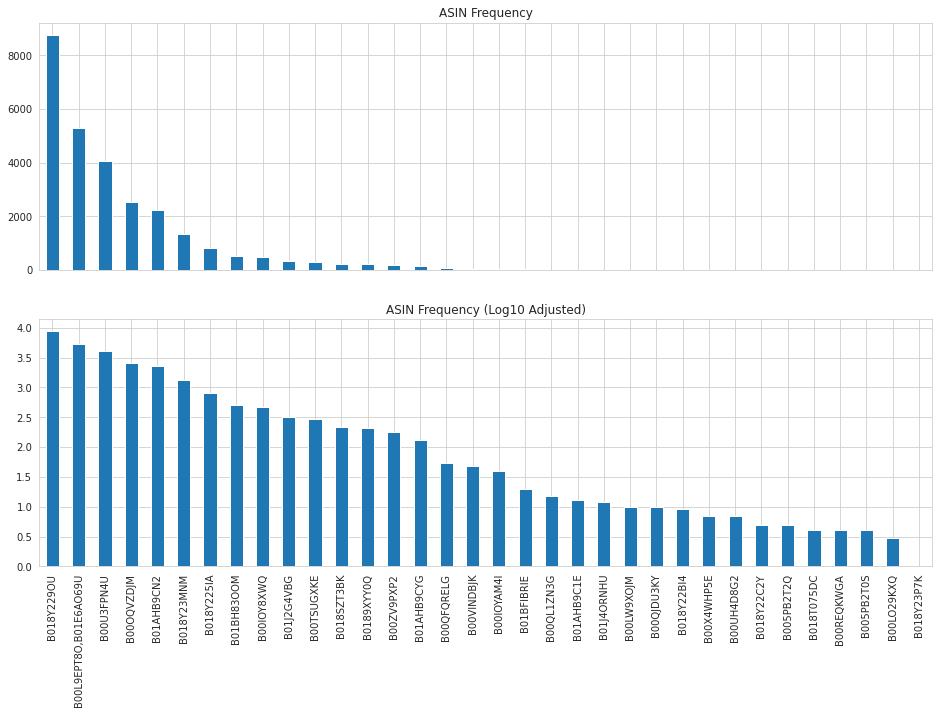

In [15]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)
reviews["asins"].value_counts().plot(kind="bar", ax=ax1, title="ASIN Frequency")
np.log10(reviews["asins"].value_counts()).plot(kind="bar", ax=ax2, title="ASIN Frequency (Log10 Adjusted)" )
plt.show()

## ***Note moyenne de l'ensemble de donnée d'entraînement***

4.5841072525566435


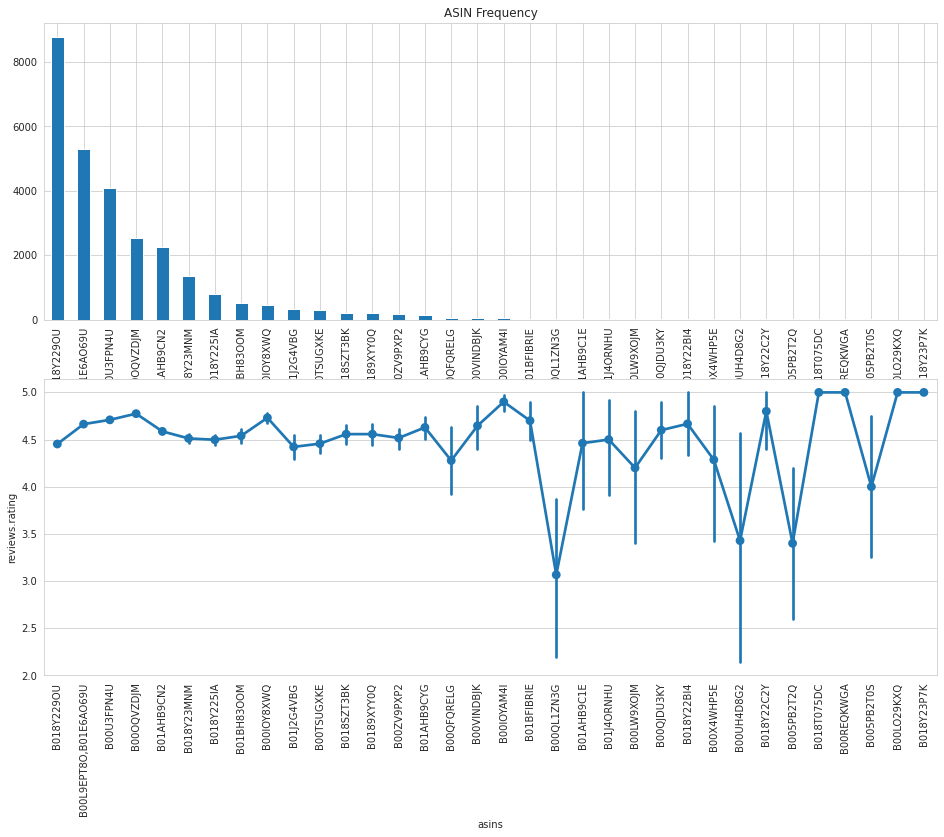

In [16]:
# Entire training dataset average rating
print(reviews["reviews.rating"].mean())

asins_count_ix = reviews["asins"].value_counts().index
plt.subplots(2,1, figsize=(16,12))
plt.subplot(2,1,1)
reviews["asins"].value_counts().plot(kind="bar", title="ASIN Frequency")
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.rating", order=asins_count_ix, data=reviews)
plt.xticks(rotation=90)
plt.show()

## ***Analyse des sentiments***  
  
En utilisant les fonctionnalités en place, nous allons créer un classificateur qui peut déterminer le sentiment d'un avis. 

In [17]:
def sentiments(rating):
  if (rating == 5) or (rating == 4):
    return "Positive"
  elif rating == 3:
    return "Neutral"
  elif (rating == 2) or (rating == 1):
    return "Negative"

# Add sentiments to the data 
strat_train["Sentiment"] = strat_train["reviews.rating"].apply(sentiments)
strat_test["Sentiment"] = strat_test["reviews.rating"].apply(sentiments)

print(strat_train["Sentiment"][:20])

4349     Positive
30776    Positive
28775     Neutral
1136     Positive
17803    Positive
7336     Positive
32638    Positive
13995    Positive
6728     Negative
22009    Positive
11047    Positive
22754    Positive
5578     Positive
11673    Positive
19168    Positive
14903    Positive
30843    Positive
5440     Positive
28940    Positive
31258    Positive
Name: Sentiment, dtype: object
